In [1]:
import numpy as np 
from array import array
from os.path  import join
import matplotlib.pyplot as plt
import struct

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
# Loading the MNIST dataset
%matplotlib inline
import random
import matplotlib.pyplot as plt


input_path = '/Users/parasmalik/Documents/Assignment_SigTuple/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


In [4]:
X_train = np.array(x_train)
Y_train = np.array(y_train)
X_test = np.array(x_test)
Y_test = np.array(y_test)

m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

# Printing the dataset values
print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 1)")
print ("train_x_orig shape: " + str(X_train.shape))
print ("train_y shape: " + str(Y_train.shape))
print ("test_x_orig shape: " + str(X_test.shape))
print ("test_y shape: " + str(Y_test.shape))

Number of training examples: 60000
Number of testing examples: 10000
Each image is of size: (28, 28, 1)
train_x_orig shape: (60000, 28, 28)
train_y shape: (60000,)
test_x_orig shape: (10000, 28, 28)
test_y shape: (10000,)


In [5]:
# Flattening the imgaes 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T 
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1
train_X = X_train_flatten / 255.
test_X = X_test_flatten / 255.

# one-hot encoding of labesls for back propagating
digits = 10
train_Y = np.eye(digits)[Y_train.astype('int32')]
train_Y = train_Y.T.reshape(digits, 60000)
test_Y = np.eye(digits)[Y_test.astype('int32')]
test_Y = test_Y.T.reshape(digits, 10000)

In [6]:
# Tuning Hyperparameters
"""
After performing the experiment on various architect I got the best result with 2 dimensional Neural Network where 
the 1st activation function is relu
"""
n_x = 784     
n_h = 64
n_y = 10
layers_dims = (n_x, n_h, n_y)
lr = 0.03 #learning rate
beta= 0.9
epochs = 100
batch_size = 64

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y,1))  
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

params = initialize_parameters(n_x, n_h, n_y)

In [10]:
def sigmoid(Z):
    s = 1. / (1. + np.exp(-Z))
    return s

def relu(Z):
    A = np.maximum(0,Z)
    return A

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ



In [11]:
def compute_loss(AL, Y):

    m = Y.shape[1]
    logloss = np.multiply(np.log(AL), Y) + np.multiply((1 - Y), np.log(1 - AL))
    cost = -1/m*np.sum(logloss)
    
    cost = np.squeeze(cost)
    
    return cost

In [12]:
def forward_propagation(X, params):
    
    cache = {}
    # Z1 = W1.dot(x) + b1
    cache["Z1"] = (params["W1"]@ X) + params["b1"]
    # A1 = relu(Z1)
    cache["A1"] = relu(cache["Z1"])
    # Z2 = W2.dot(A1) + b2
    cache["Z2"] = (params["W2"]@cache["A1"]) + params["b2"]
    # A2 = softmax(Z2)
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)
    return cache



In [13]:
def back_propagate(X, Y, params, cache, m_batch):
    
    dZ2 = cache["A2"] - Y
    dW2 = (1. / m_batch) * (dZ2@cache["A1"].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = params["W2"].T@ dZ2
    dZ1 = relu_backward(dA1,cache["Z1"])
    dW1 = (1. / m_batch) * (dZ1@X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

In [14]:
batches = 60000//batch_size
#Training on 100 epochs with weight updates happed after each bacth of 64 examples

for i in range(epochs):
    
    for j in range(batches):
        
        begin = j * batch_size
        end = min(begin + batch_size, 60000 - 1)
        X = train_X[:, begin:end]
        Y = train_Y[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = forward_propagation(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)
        
        # Finding partial derivatives of loss w.r.t. weights
        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        dW1 = (beta * dW1 + (1. - beta) * grads["dW1"])
        db1 = (beta * db1 + (1. - beta) * grads["db1"])
        dW2 = (beta * dW2 + (1. - beta) * grads["dW2"])
        db2 = (beta * db2 + (1. - beta) * grads["db2"])

        # gradient descent and updating weights
        params["W1"] = params["W1"] - lr * dW1
        params["b1"] = params["b1"] - lr * db1
        params["W2"] = params["W2"] - lr * dW2
        params["b2"] = params["b2"] - lr * db2

    cache = forward_propagation(train_X, params)
    train_loss = compute_loss( cache["A2"],train_Y)

    cache = forward_propagation(test_X, params)
    test_loss = compute_loss( cache["A2"],test_Y)
    print("Epoch {}: training loss = {}".format(
        i + 1, train_loss))
    
    test_prediction = forward_propagation(test_X, params)
    Y_predicted = np.argmax(test_prediction["A2"],axis = 0)
    result = np.sum(np.where(Y_predicted == Y_test, 1,0))

    Accuracy = result/m_test 

    print("Accuracy on test set is {} %".format(100*Accuracy))

    

Epoch 1: training loss = 0.74867365893571
Accuracy on test set is 87.66000000000001 %
Epoch 2: training loss = 0.5743661616985307
Accuracy on test set is 90.39 %
Epoch 3: training loss = 0.5101266841701566
Accuracy on test set is 91.55 %
Epoch 4: training loss = 0.46518059683033613
Accuracy on test set is 92.31 %
Epoch 5: training loss = 0.42563130157463136
Accuracy on test set is 92.93 %
Epoch 6: training loss = 0.3909075107194864
Accuracy on test set is 93.42 %
Epoch 7: training loss = 0.3612496098991478
Accuracy on test set is 93.89999999999999 %
Epoch 8: training loss = 0.3364471261077634
Accuracy on test set is 94.28 %
Epoch 9: training loss = 0.31480006413338674
Accuracy on test set is 94.67 %
Epoch 10: training loss = 0.29609097544700586
Accuracy on test set is 94.89 %
Epoch 11: training loss = 0.2795115467340682
Accuracy on test set is 95.09 %
Epoch 12: training loss = 0.26476064824327367
Accuracy on test set is 95.34 %
Epoch 13: training loss = 0.2513732867757008
Accuracy on t

In [15]:
# prediction of All Test Imagees
#print(np.argmax(test_prediction["A2"],axis = 0))
#print(Y_test)

Y_predicted = np.argmax(test_prediction["A2"],axis = 0)
result = np.sum(np.where(Y_predicted == Y_test, 1,0))

Accuracy = result/m_test 

print("Accuracy on test set is", 100*Accuracy,"%")

Accuracy on test set is 97.72999999999999 %


Select any random image index 203
Actual number 1
Predicted value through our model
[1]


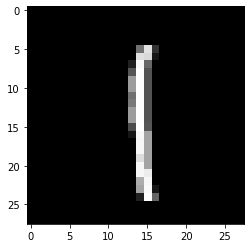

In [20]:
# Picking any random image and checking the output

k = int(input("Select any random image index "))
print("Actual number",Y_test[k])
plt.imshow(x_test[k], cmap=plt.cm.gray)
test_X_1 = test_X.T
test_X_1 = test_X_1[k]
test_X_1 = test_X_1.reshape(784,-1)
predict = forward_propagation(test_X_1,params)
print("Predicted value through our model")
print(np.argmax(predict["A2"],axis = 0))
